In [1]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Import relevant packages
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import sys

In [3]:
# Initialise Bayesian Net
model = BayesianNetwork([('Smoking', 'Yellow Fingers'), ('Smoking', 'Cancer'), ('Solar Flares', 'Radiation'), ('Microwave', 'Radiation'), ('Radiation', 'Cancer'), ('Radiation', 'Skin Burn')])

# Prior probability of smoking
cpd_S = TabularCPD(variable='Smoking', variable_card=2, values=[[0.8], [0.2]])

# Prior probability of solar flares
cpd_F = TabularCPD(variable='Solar Flares', variable_card=2, values=[[0.999], [0.001]])

# Prior probability of microwave
cpd_M = TabularCPD(variable='Microwave', variable_card=2, values=[[0.1], [0.9]])

In [4]:
# Conditional probability for Radiation or P(R | F,M)
cpd_R = TabularCPD(variable='Radiation',variable_card=2, values = [
                                  [0.99, 0.9, 0.7, 0.5],
                                  [0.01, 0.1, 0.3, 0.5]],
                                  evidence = ['Solar Flares', 'Microwave'],
                                  evidence_card=[2, 2])

# Conditional probability for Cancer or P(C | S,R)
cpd_C = TabularCPD(variable='Cancer',variable_card=2, values = [
                                  [0.9, 0.4, 0.8, 0.1],
                                  [0.1, 0.6, 0.2, 0.9]],
                                  evidence = ['Smoking', 'Radiation'],
                                  evidence_card=[2, 2])

# Conditional probability for Yellow Fingers or P(Y | S)
cpd_Y = TabularCPD(variable='Yellow Fingers',variable_card=2, values = [
                                  [0.9, 0.1],
                                  [0.1, 0.9]],
                                  evidence = ['Smoking'],
                                  evidence_card=[2])

# Conditional probability for Skin Burn or P(B | R)
cpd_B = TabularCPD(variable='Skin Burn',variable_card=2, values = [
                                  [0.99, 0.9],
                                  [0.01, 0.1]],
                                  evidence = ['Radiation'],
                                  evidence_card=[2])

model.add_cpds(cpd_S, cpd_F, cpd_M, cpd_R, cpd_C, cpd_Y, cpd_B)

## Validate network parameters

In [5]:
print(model.check_model())
print(model.get_cpds('Smoking'))

True
+------------+-----+
| Smoking(0) | 0.8 |
+------------+-----+
| Smoking(1) | 0.2 |
+------------+-----+


### 1. Draw the Bayesian network clearly showing the nodes and arrows showing relationship among all the variables.

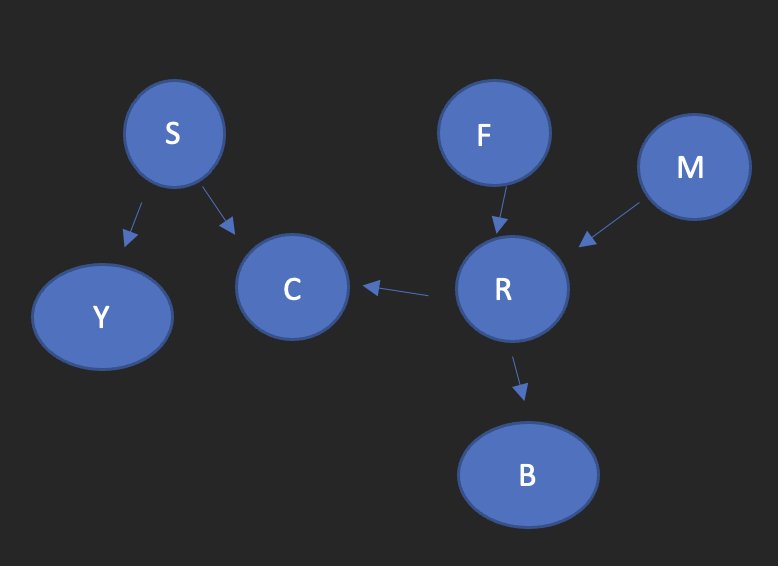

### 2. What is the probability of radiation given Cancer = 1? Show values for R=0, R=1

In [6]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

In [7]:
# Compute probability of Radiation given Cancer =1
phi_query = infer.query(['Radiation'], evidence={'Cancer':1})
print('Probability of radiation given Cancer = 1')
print(phi_query)

Probability of radiation given Cancer = 1
+--------------+------------------+
| Radiation    |   phi(Radiation) |
+==============+==================+
| Radiation(0) |           0.6438 |
+--------------+------------------+
| Radiation(1) |           0.3562 |
+--------------+------------------+


### 3. What is the probability of cancer given Skin Burn = 1? Show values for C=0, C=1

In [8]:
phi_query = infer.query(['Cancer'], evidence={'Skin Burn':1})
print('Probability of cancer given Skin Burn = 1')
print(phi_query)

Probability of cancer given Skin Burn = 1
+-----------+---------------+
| Cancer    |   phi(Cancer) |
+===========+===============+
| Cancer(0) |        0.6092 |
+-----------+---------------+
| Cancer(1) |        0.3908 |
+-----------+---------------+


### 4. Are Smoking and using microwave independent given cancer? Justify your answer.

No, smoking and using microwave are not independent given cancer.

Given the Bayesian Network in 1., the trail between Smoking (S) and Microwave (M) is active given Cancer (C).

The only trail between S and M is as follows: S -> C <- R <- M, and the evidence set E = {C}

There exists a V-structure on the node C, but C is in the evidence set. This means the trail is active. Since all trails between S and M are active, S and M are not d-separated, hence Smoking and using Microwave are not independent given cancer.

### 5. What is the probability of cancer = 1 if you never use a microwave?

In [9]:
phi_query = infer.query(['Cancer'], evidence={'Microwave':0})
print('Probability of cancer given Microwave = 0')
print(phi_query)

Probability of cancer given Microwave = 0
+-----------+---------------+
| Cancer    |   phi(Cancer) |
+===========+===============+
| Cancer(0) |        0.8744 |
+-----------+---------------+
| Cancer(1) |        0.1256 |
+-----------+---------------+
